In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.2 MB/s eta 0:00:00



#Task 2: Implementations of Variational Classifiers

## 2.1 Variational Quantum Classifier for Parity Function

### Overview

This section implements a variational quantum classifier for the parity function using PennyLane, a quantum machine learning framework. The parity function is a binary classification task where the output is 1 if the input bitstring has an odd number of 1s, and 0 otherwise.


### Imports and Setup

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

# Set up the quantum device
dev = qml.device("default.qubit", wires=4)

In this step, we import the necessary libraries and set up a quantum device with 4 qubits. PennyLane is our quantum machine learning framework, and we use its version of NumPy for compatibility.

### Layer Function

In [3]:
def layer(weights):
    for wire in range(4):
        qml.Rot(*weights[wire], wires=wire)
    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

This function defines a single layer of our variational circuit. It applies rotation gates to each qubit, followed by CNOT gates in a ring structure. This creates entanglement between qubits, which is crucial for the expressivity of our quantum circuit.

### State Preparation

In [4]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

This function encodes our input data (bitstrings) into the quantum state. It uses basis encoding, where each qubit is set to |0⟩ or |1⟩ based on the input bits.

### Quantum Circuit

In [5]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)
    for layer_weights in weights:
        layer(layer_weights)
    return qml.expval(qml.PauliZ(0))

This is our full quantum circuit. It prepares the initial state based on the input, applies multiple layers of our variational circuit, and measures the expectation value of the PauliZ operator on the first qubit.

### Variational Classifier

In [6]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

This function combines the quantum circuit output with a classical bias term, forming our complete classifier.

### Loss Function and Accuracy

In [7]:
def square_loss(labels, predictions):
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    return np.mean(np.abs(labels - predictions) < 1e-5)

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

These functions define our loss (square loss), accuracy metric, and cost function. The cost function computes predictions for a batch of inputs and calculates the loss.

### Data Loading and Preprocessing

In [8]:
data = np.loadtxt("parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

Here we load the training data and preprocess the labels to be in {-1, 1} instead of {0, 1}.

### Model Initialization

In [9]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

We initialize our model parameters (weights and bias) randomly.

### Training Loop

In [10]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init

for it in range(100):
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    if (it + 1) % 10 == 0:
        print(f"Iter: {it+1:4d} | Cost: {cost(weights, bias, X, Y):0.7f} | Accuracy: {acc:0.7f}")

Iter:   10 | Cost: 1.1349618 | Accuracy: 0.6000000
Iter:   20 | Cost: 1.1868237 | Accuracy: 0.6000000
Iter:   30 | Cost: 1.1287654 | Accuracy: 0.6000000
Iter:   40 | Cost: 1.7571779 | Accuracy: 0.4000000
Iter:   50 | Cost: 0.8549226 | Accuracy: 0.6000000
Iter:   60 | Cost: 0.0058108 | Accuracy: 1.0000000
Iter:   70 | Cost: 0.0015856 | Accuracy: 1.0000000
Iter:   80 | Cost: 0.0001330 | Accuracy: 1.0000000
Iter:   90 | Cost: 0.0000759 | Accuracy: 1.0000000
Iter:  100 | Cost: 0.0000174 | Accuracy: 1.0000000


This is our training loop. We use the Nesterov Momentum optimizer and update our model parameters and print the cost and accuracy every 10 iterations.

### Test Evaluation

In [11]:
test_data = np.loadtxt("parity_test.txt", dtype=int)
X_test = np.array(test_data[:, :-1])
Y_test = np.array(test_data[:, -1])
Y_test = Y_test * 2 - 1

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]
acc_test = accuracy(Y_test, predictions_test)
print(f"Test Accuracy: {acc_test:0.7f}")

Test Accuracy: 1.0000000


Finally, we evaluate our trained model on a separate test set to assess its generalization performance, which turns out to be 100%.

### Training using the Adam Optimizer

In [16]:
from pennylane.optimize import AdamOptimizer

opt = AdamOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init

for it in range(100):
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    if (it + 1) % 10 == 0:
        print(f"Iter: {it+1:4d} | Cost: {cost(weights, bias, X, Y):0.7f} | Accuracy: {acc:0.7f}")

Iter:   10 | Cost: 0.7056677 | Accuracy: 0.6000000
Iter:   20 | Cost: 0.2706393 | Accuracy: 1.0000000
Iter:   30 | Cost: 0.1356019 | Accuracy: 1.0000000
Iter:   40 | Cost: 0.0244339 | Accuracy: 1.0000000
Iter:   50 | Cost: 0.0130315 | Accuracy: 1.0000000
Iter:   60 | Cost: 0.0007030 | Accuracy: 1.0000000
Iter:   70 | Cost: 0.0013221 | Accuracy: 1.0000000
Iter:   80 | Cost: 0.0002743 | Accuracy: 1.0000000
Iter:   90 | Cost: 0.0001071 | Accuracy: 1.0000000
Iter:  100 | Cost: 0.0000315 | Accuracy: 1.0000000


It can be seen that `AdamOptimizer` converged faster, reaching 100% accuracy by iteration 20. Whereas `NesterovMomentumOptimizer` took until iteration 60 to reach 100% accuracy.

Both optimizers achieved very low cost by the end, with `AdamOptimizer` slightly higher (0.0000315 vs 0.0000174).

## 2.2 Variational Quantum Classifier for Amplitude Encoded Iris Dataset

### Overview

In this section, we explore the use of amplitude encoding for classifying real-valued data from the Iris dataset. Unlike the bitstring encoding used for the parity function, amplitude encoding allows us to represent real-valued vectors as quantum states.

### Key Differences from Parity Classifier

1. **Encoding**: Uses amplitude encoding instead of basis encoding.
2. **Data Type**: Handles continuous, real-valued data instead of binary data.
3. **Circuit Structure**: Uses fewer qubits (2) but more layers (6) compared to the parity classifier.

### Data Preprocessing

To encode the real-valued data from the Iris dataset into quantum states, we follow these steps:
1. **Padding**: Adding latent dimensions to the data points.
2. **Normalization**: Ensuring the data points are normalized to unit length.
3. **Angle Conversion**: Translating normalized inputs into rotation angles.

### Implementation

In [2]:
# Import required libraries
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt

# Initialize the quantum device
dev = qml.device("default.qubit", wires=2)

# Function to compute angles for state preparation
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

# State preparation function
def state_preparation(a):
    qml.RY(a[0], wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)
    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

# Define the variational circuit
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)
    for layer_weights in weights:
        layer(layer_weights)
    return qml.expval(qml.PauliZ(0))

# Define the variational classifier
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

# Define the cost function
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

# Define the layer function for the variational circuit
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

# Define the square loss function
def square_loss(labels, predictions):
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

# Define the accuracy function
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

# Load and preprocess the Iris dataset
data = np.loadtxt("iris_classes1and2_scaled.txt")
X = data[:, 0:2]
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
Y = data[:, -1]

# Split data into training and validation sets
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# Initialize weights and bias
num_qubits = 2
num_layers = 6
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

# Create optimizer instance
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# Training loop
weights = weights_init
bias = bias_init
for it in range(60):
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}")



Iter:     2 | Cost: 1.6589456 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2054273 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9740740 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:     8 | Cost: 0.9660872 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    10 | Cost: 0.9569019 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    12 | Cost: 0.9445863 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:    14 | Cost: 1.0339978 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    16 | Cost: 1.0774217 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    18 | Cost: 0.9984426 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.8975279 | Acc train: 0.5600000 | Acc validation: 0.7600000
Iter:    22 | Cost: 0.8451699 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    24 | Cost: 0.8337489 | Acc train: 0.5600000 | Acc validation: 0.5200000
Iter:    26 | Cost: 0.783202

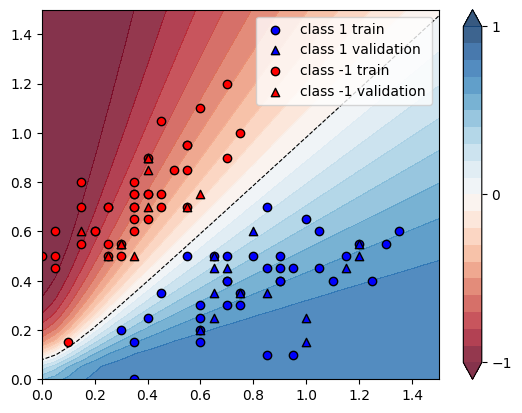

In [3]:
# Visualize the decision boundary
plt.figure()
cm = plt.cm.RdBu
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T
features_grid = np.array([get_angles(x) for x in X_grid])
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

This implementation of a variational classifier using amplitude encoding demonstrates the potential of quantum machine learning for classifying real-valued data. The model successfully learned to separate the two classes in the Iris dataset, achieving 100% accuracy on both training and validation sets.

Convergence of this implementation is slower compared to the parity classifier, likely due to the more complex nature of the data and encoding.